# Вариационный автоэнкодер

Мотивация: нам никто вообще не гарантирует, что автоэнкодер работает, и что у него какое-то адекватное латентное пространство.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import tqdm

In [2]:
dataset = datasets.MNIST('mnist', train=True, download=True, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Processing...
Done!


In [3]:
class View(nn.Module):
    def __init__(self, shape):
        self.shape = shape
    
    def forward(self, x):
        return x.view(*shape)

In [13]:
class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=256, z_dim=32):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        
        self.h2mu = nn.Linear(h_dim, z_dim)
        self.h2sigma = nn.Linear(h_dim, z_dim)
        self.z2h = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        # если не понимаете, как это работает, спросите
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size())
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu = self.h2mu(h)
        logvar = self.h2sigma(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def encode(self, x):
        # это можно использовать для морфинга, например
        return self.bottleneck(self.encoder(x))[0]

    def decode(self, z):
        return self.decoder(self.z2h(z))
    
    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.z2h(z)
        return self.decoder(z), mu, logvar

In [14]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [15]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
for epoch in range(10):
    train_loss = 0
    for data, _ in tqdm.tqdm(loader):
        # если вам лень писать свёртки:
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        
        train_loss += loss.item()
        
        optimizer.step()
        
    print('epoch %d, loss %.4f' % (epoch, train_loss / len(dataset)))

  0%|          | 3/938 [00:00<00:41, 22.63it/s]

epoch 0, loss 149.2548


  0%|          | 2/938 [00:00<01:01, 15.31it/s]

epoch 1, loss 117.0835


  0%|          | 2/938 [00:00<00:54, 17.30it/s]

epoch 2, loss 112.1497


  0%|          | 2/938 [00:00<00:59, 15.86it/s]

epoch 3, loss 109.6293


  0%|          | 2/938 [00:00<00:52, 17.94it/s]

epoch 4, loss 107.8059


  0%|          | 2/938 [00:00<00:51, 18.16it/s]

epoch 5, loss 106.6297


  0%|          | 2/938 [00:00<00:54, 17.32it/s]

epoch 6, loss 105.7905


  0%|          | 2/938 [00:00<00:53, 17.50it/s]

epoch 7, loss 105.1655


  0%|          | 2/938 [00:00<00:49, 18.72it/s]

epoch 8, loss 104.6264


100%|██████████| 938/938 [00:48<00:00, 18.81it/s]

epoch 9, loss 104.1676


In [23]:
from matplotlib import animation
from IPython.display import HTML, display
import numpy as np
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

In [26]:
def get(x):
    return dataset[x][0].view(1, 784)  # измените формат, если хотите использовать свёртки

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in np.linspace(0, 1, steps):
            c = a*(1-t)+b*t
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

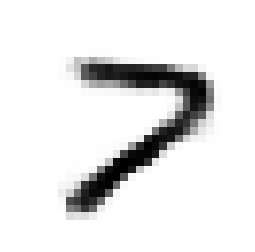

In [27]:
morph(np.random.randint(0, len(dataset), 30), 20, 30)

Дополнительное чтение для ноулайферов: [Tutorial on Variational Autoencoders](https://arxiv.org/pdf/1606.05908.pdf).

# EM-алгоритм

Это задание было украдено с Deep Bayes 2018, а там оно в свою очередь было украдено у Чешского технического универсистета.

Данные скачать можно тут: https://goo.gl/6eD3BB

Немного помучайтесь с математикой, а когда надоест, посмотрите выводы формул здесь: https://github.com/bayesgroup/deepbayes-2018/blob/master/day1_em/seminar_em.pdf

Легенда такая: есть $K$ изображений, на которых изображен один из организаторов DeepBayes, но все из них были повреждены следующим процессом: есть фиксированное черно-белое изображение-фон $B$ (размера $W \times H$), в каждом изоражении лицо $F$ (размера $w \times H$) помещается в случайное место на фоне (для каждого изображения выбирается горизонтальный сдвиг $d_k$; априорные вероятности каждого сдвига обучаемы). Помимо этого, ко всем изображениям подмешивается белый шум (независимо ко всем пикселям) со средним 0 и дисперсией $s^2$.

Ваша задача — восстановить лицо. Формально, нужно найти такую матрицу, что правдоподобие сгенерированных изображений максимально.

In [0]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
w = 73  # ширина лица
X = np.load("data_em")  # путь до данных

In [0]:
plt.imshow(X[:, :, 0], cmap="Greys_r")
plt.axis("off")

Наша цель — найти лицо $F$ (матрица размера $H \times w$).

Также в процессе нам потребуется найти:
* $B$: фон  ($H \times W$)
* $s^2$: дисперсию шума (скаляр)
* $a$: априорные вероятности сдвигов ($W-w+1$ штук, должны суммироваться в единицу)
* $q(d)$: постериорные вероятности сдвигов для каждого изображения  (($W-w+1$) x $K$)

План реализации такой:
1. Вычислить $\log p(X  \mid d,\,F,\,B,\,s)$
2. E-шаг: посчитать $q(d)$
3. M-шаг: найти самые правдоподобные $F,\, B, \,s, \,a$
4. Соединить вместе E-шаг и M-шаг

In [0]:
# EM-алгоритм может работать долго, и на больших данных его трудно тестировать
tH, tW, tw, tK = 2, 3, 1, 2
tX = np.arange(tH*tW*tK).reshape(tH, tW, tK)
tF = np.arange(tH*tw).reshape(tH, tw)
tB = np.arange(tH*tW).reshape(tH, tW)
ts = 0.1
ta = np.arange(1, (tW-tw+1)+1)
ta = ta / ta.sum()
tq = np.arange(1, (tW-tw+1)*tK+1).reshape(tW-tw+1, tK)
tq = tq / tq.sum(axis=0)[np.newaxis, :]

## Вычисляем лог-вероятности

Для $k$-го изображения $X_k$ и сдвига $d_k$, его правдоподобие будет равно:

$$p(X_k  \mid d_k,\,F,\,B,\,s) = \prod_{ij}
    \begin{cases} 
    	\mathcal{N}(X_k[i,j]\mid F[i,\,j-d_k],\,s^2), 
    	& \text{if}\, (i,j)\in faceArea(d_k)\\
    	\mathcal{N}(X_k[i,j]\mid B[i,j],\,s^2), & \text{else}
    \end{cases}$$

Примечание:
* Не забудьте, что нам нужен логарифм всего этого.
* Желательно использовать не более одного цикла.

In [0]:
def calculate_log_probability(X, F, B, s):
    """
    Calculates log p(X_k|d_k, F, B, s) for all images X_k in X and
    all possible face position d_k.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    F : array, shape (H, w)
        Estimate of prankster's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.

    Returns
    -------
    ll : array, shape(W-w+1, K)
        ll[dw, k] - log-likelihood of observing image X_k given
        that the prankster's face F is located at position dw
    """
    # your code here

In [0]:
# run this cell to test your implementation
expected = np.array([[-3541.69812064, -5541.69812064],
       [-4541.69812064, -6741.69812064],
       [-6141.69812064, -8541.69812064]])
actual = calculate_log_probability(tX, tF, tB, ts)
assert np.allclose(actual, expected)

## `сalculate_lower_bound`

$$\mathcal{L}(q, \,F, \,B,\, s,\, a) = \sum_k \biggl (\mathbb{E} _ {q( d_k)}\bigl ( \log p(  X_{k}  \mid {d}_{k} , \,F,\,B,\,s) + 
    \log p( d_k  \mid a)\bigr) - \mathbb{E} _ {q( d_k)} \log q( d_k)\biggr) $$
    
Примечания:
* Вы уже реализовали `calculate_log_probability` — используйте её. 
* Распределения $q(d_k)$ и $p( d_k  \mid a)$ дискретные. For example, $P(d_k=i \mid a) = a[i]$.
* Старайтесь не использовать циклы.

In [0]:
def calculate_lower_bound(X, F, B, s, a, q):
    """
    Calculates the lower bound L(q, F, B, s, a) for 
    the marginal log likelihood.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    F : array, shape (H, w)
        Estimate of prankster's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.
    a : array, shape (W-w+1)
        Estimate of prior on position of face in any image.
    q : array
        q[dw, k] - estimate of posterior 
                   of position dw
                   of prankster's face given image Xk

    Returns
    -------
    L : float
        The lower bound L(q, F, B, s, a) 
        for the marginal log likelihood.
    """
    # your code here

In [0]:
expected = -12761.1875
actual = calculate_lower_bound(tX, tF, tB, ts, ta, tq)
assert np.allclose(actual, expected)

## E-step

$$q(d_k) = p(d_k \mid X_k, \,F, \,B, \,s,\, a) = 
\frac {p(  X_{k}  \mid {d}_{k} , \,F,\,B,\,s)\, p(d_k \mid a)}
{\sum_{d'_k} p(  X_{k}  \mid d'_k , \,F,\,B,\,s) \,p(d'_k \mid a)}$$

Примечания:
* Используйте `calculate_log_probability`.
* Ради вычислительной стабильности, используйте операции с логарифмированными значениями и только в конце возводите в экспоненту. Также используйте этот трюк с софтмаксом:
$$\beta_i = \log{p_i(\dots)} \quad\rightarrow \quad
	\frac{e^{\beta_i}}{\sum_k e^{\beta_k}} = 
	\frac{e^{(\beta_i - \max_j \beta_j)}}{\sum_k e^{(\beta_k- \max_j \beta_j)}}$$
* Старайтесь не использовать циклы

In [0]:
def run_e_step(X, F, B, s, a):
    """
    Given the current esitmate of the parameters, for each image Xk
    esitmates the probability p(d_k|X_k, F, B, s, a).

    Parameters
    ----------
    X : array, shape(H, W, K)
        K images of size H x W.
    F  : array_like, shape(H, w)
        Estimate of prankster's face.
    B : array shape(H, W)
        Estimate of background.
    s : float
        Eestimate of standard deviation of Gaussian noise.
    a : array, shape(W-w+1)
        Estimate of prior on face position in any image.

    Returns
    -------
    q : array
        shape (W-w+1, K)
        q[dw, k] - estimate of posterior of position dw
        of prankster's face given image Xk
    """
    # your code here

In [0]:
expected = np.array([[ 1.,  1.],
                   [ 0.,  0.],
                   [ 0.,  0.]])
actual = run_e_step(tX, tF, tB, ts, ta)
assert np.allclose(actual, expected)
print("OK")

## M-step

$$a[j] = \frac{\sum_k q( d_k = j )}{\sum_{j'}  \sum_{k'} q( d_{k'} = j')}$$
$$F[i, m] = \frac 1 K  \sum_k \sum_{d_k} q(d_k)\, X^k[i,\, m+d_k]$$
$$B[i, j] = \frac {\sum_k \sum_{ d_k:\, (i, \,j) \,\not\in faceArea(d_k)} q(d_k)\, X^k[i, j]} 
	  	{\sum_k \sum_{d_k: \,(i, \,j)\, \not\in faceArea(d_k)} q(d_k)}$$
$$s^2 = \frac 1 {HWK}   \sum_k \sum_{d_k} q(d_k)
	  	\sum_{i,\, j}  (X^k[i, \,j] - M^{d_k}[i, \,j])^2$$

где $M^{d_k}[i, j]$ это изображение из фона, с наложенным на него лицом со сдвигом $d_k$.

Примечания:
* Порядок обновления параметров: $a$, $F$, $B$, $s$.
* Когда параметр обновляется, его __новое__ значение используется для обновления других параметров.
* Используйте не более 3 циклов (отдельных, не вложенных).

In [0]:
def run_m_step(X, q, w):
    """
    Estimates F, B, s, a given esitmate of posteriors defined by q.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    q  :
        q[dw, k] - estimate of posterior of position dw
                   of prankster's face given image Xk
    w : int
        Face mask width.

    Returns
    -------
    F : array, shape (H, w)
        Estimate of prankster's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.
    a : array, shape (W-w+1)
        Estimate of prior on position of face in any image.
    """
    # your code here

In [0]:
expected = [
    np.array([[ 3.27777778],
              [ 9.27777778]]),
    np.array([[  0.48387097, 2.5       ,   4.52941176],
              [  6.48387097, 8.5       ,  10.52941176]]),
    0.94868,
    np.array([ 0.13888889,  0.33333333,  0.52777778])
]
actual = run_m_step(tX, tq, tw)
for a, e in zip(actual, expected):
    assert np.allclose(a, e)

## Соединяем всё вместе

Инициализируйте чем-нибудь параметры, и повторяйте E- и M-шаги до сходимости. $\mathcal{L}(q, \,F, \,B, \,s, \,a)$ должна строго увеличиваться после каждой итерации.

In [0]:
def run_EM(X, w, F=None, B=None, s=None, a=None, tolerance=0.001, max_iter=50):
    """
    Runs EM loop until the likelihood of observing X given current
    estimate of parameters is idempotent as defined by a fixed
    tolerance.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    w : int
        Face mask width.
    F : array, shape (H, w), optional
        Initial estimate of prankster's face.
    B : array, shape (H, W), optional
        Initial estimate of background.
    s : float, optional
        Initial estimate of standard deviation of Gaussian noise.
    a : array, shape (W-w+1), optional
        Initial estimate of prior on position of face in any image.
    tolerance : float, optional
        Parameter for stopping criterion.
    max_iter  : int, optional
        Maximum number of iterations.

    Returns
    -------
    F, B, s, a : trained parameters.
    LL : array, shape(number_of_iters + 2,)
        L(q, F, B, s, a) at initial guess, 
        after each EM iteration and after
        final estimate of posteriors;
        number_of_iters is actual number of iterations that was done.
    """
    H, W, N = X.shape
    if F is None:
        F = np.random.randint(0, 255, (H, w))
    if B is None:
        B = np.random.randint(0, 255, (H, W))
    if a is None:
        a = np.ones(W - w + 1)
        a /= np.sum(a)
    if s is None:
        s = np.random.rand()*pow(64,2)
    # your code here

In [0]:
res = run_EM(tX, tw, max_iter=3)
LL = res[-1]
assert np.alltrue(LL[1:] - LL[:-1] > 0)

## Так кто же на фотке?

In [0]:
def show(F, i=1, n=1):
    plt.subplot(1, n, i)
    plt.imshow(F, cmap="Greys_r")
    plt.axis("off")

In [0]:
F, B, s, a = [None] * 4
LL = []
lens = [50, 100, 300, 500, 1000]
iters = [5, 1, 1, 1, 1]
plt.figure(figsize=(20, 5))
for i, (l, it) in enumerate(zip(lens, iters)):
    F, B, s, a, _ = run_EM(X[:, :, :l], w, F, B, s, a, max_iter=it)
    show(F, i+1, 5)